# Kaggle: House prices - Advanced regression techniques

**Notebook contents:**
* Imports
* Exploratory data analysis
* Data cleaning and feature transformation


In [512]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from scipy import stats
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

In [513]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')

# Exploratory data analysis

# 1. Overview of SalePrice

In [514]:
train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

Skew is:  1.8828757597682129


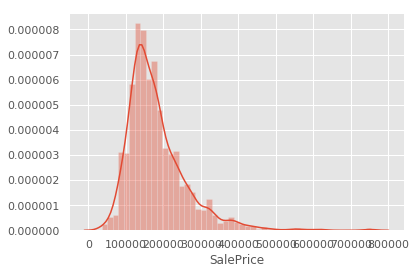

In [515]:
#saleprice distplot
sns.distplot(train['SalePrice'])
print("Skew is: ", train['SalePrice'].skew())

Positive skewness and deviation from normal distribution. **Apply log transformation**

# 2. Relationship with variables

In [516]:
quant = train.select_dtypes(include=[np.number])
quant.dtypes

corr = quant.corr()
print(corr['SalePrice'].sort_values(ascending=False)[:5])
print(corr['SalePrice'].sort_values(ascending=False)[-5:])

SalePrice      1.000000
OverallQual    0.790982
GrLivArea      0.708624
GarageCars     0.640409
GarageArea     0.623431
Name: SalePrice, dtype: float64
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePrice, dtype: float64


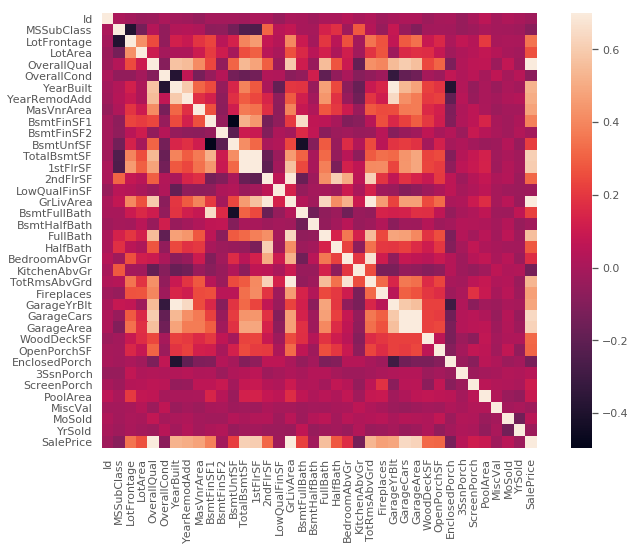

In [517]:
#correlation matrix
corr = train.corr()
f, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(corr, vmax=0.7, square=True)

GrLivArea and TotRmsAbvGrd, TotalBsmtSF and 1stFlrSF, YearBuilt and GarageYrBlt as well as GarageCars and GarageArea show significant corelation indicating a situation of multicollinearity. So, they're likely to provide similar information.

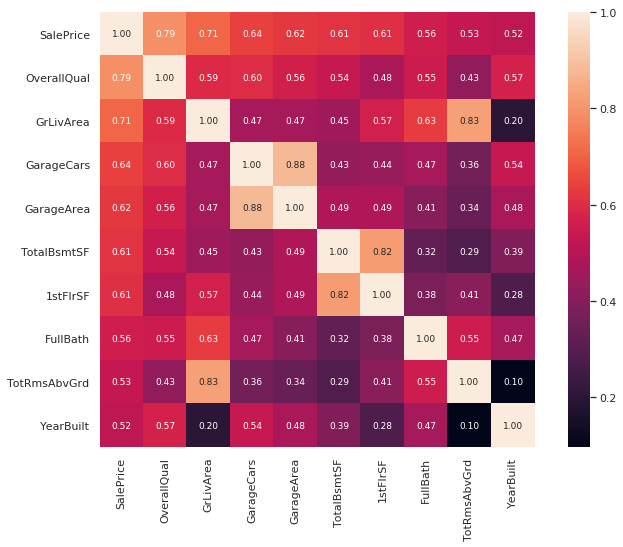

In [518]:
#saleprice correlation matrix
k = 10
col = corr.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train[col].values.T)
sns.set(font_scale=1)
f, ax = plt.subplots(figsize=(12, 8))
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 9}, yticklabels=col.values, xticklabels=col.values)
plt.show()

* OverallQual, GrLivArea and TotalBsmtSF are all strongly correlated with SalePrice.
* GarageCars and GarageArea indicate multicollinearity. Since the former has stronger correlation with SalePrice, **select GarageCars**
* Similarly, TotalBsmtSF and 1stFloor are also strongly correlated variables. **Select TotalBsmtSF**
* TotRmsAbvGrd and GrLivArea are also twins. **Select GrLivArea**

** [1] OverallQual: **

In [519]:
# pivot table to investigate relationship between OverallQual and SalePrice
quality_pivot = train.pivot_table(index='OverallQual', values='SalePrice', aggfunc=np.median)
quality_pivot

,SalePrice
OverallQual,
1,50150
2,60000
3,86250
4,108000
5,133000
6,160000
7,200141
8,269750
9,345000


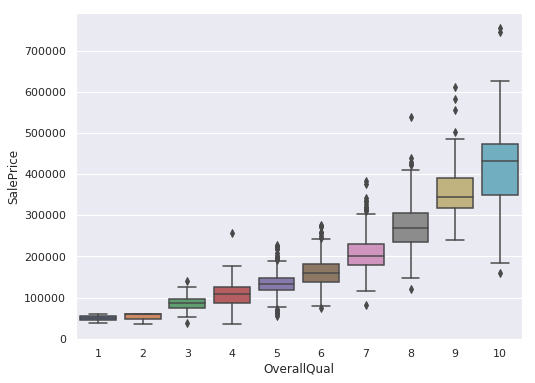

In [520]:
#Overallqual/saleprice
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x="OverallQual", y="SalePrice", data=train)

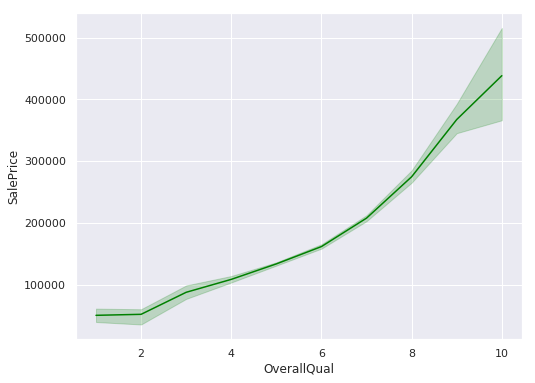

In [521]:
f, ax = plt.subplots(figsize=(8, 6))
sns.lineplot(x='OverallQual', y = train['SalePrice'], color='green',data=train)

As expected, SalePrice increases with increasing OverallQual.

** [2] GrLivArea, GarageArea and TotalBsmtSF: **

Text(0, 0.5, 'Sale price')

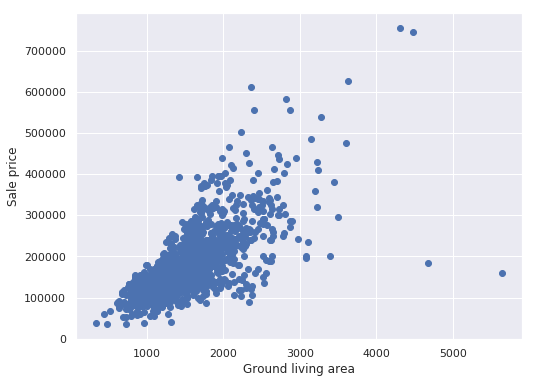

In [522]:
#GrLivArea/SalePrice
f, ax = plt.subplots(figsize=(8, 6))
plt.scatter(train['GrLivArea'],train['SalePrice'])
plt.xlabel('Ground living area')
plt.ylabel('Sale price')

Text(0, 0.5, 'Sale price')

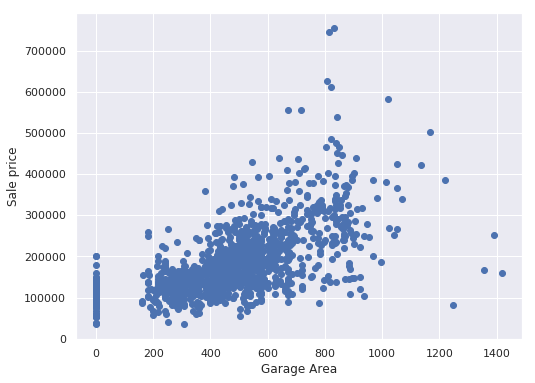

In [523]:
#GarageArea/SalePrice
f, ax = plt.subplots(figsize=(8, 6))
plt.scatter(train['GarageArea'],train['SalePrice'])
plt.xlabel('Garage Area')
plt.ylabel('Sale price')

Text(0, 0.5, 'Sale price')

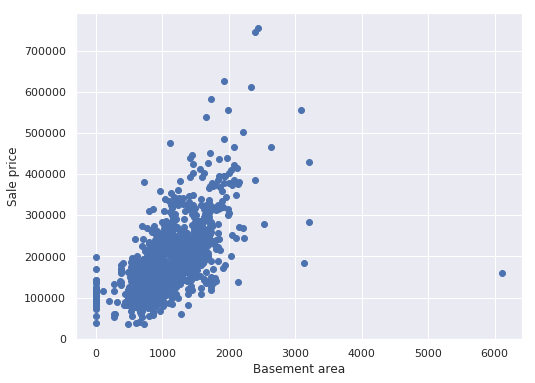

In [524]:
#TotalBsmtSF/SalePrice
f, ax = plt.subplots(figsize=(8, 6))
plt.scatter(train['TotalBsmtSF'],train['SalePrice'])
plt.xlabel('Basement area')
plt.ylabel('Sale price')

GrLivArea, GarageArea and TotalBsmtSF have a linear relationship with SalePrice

** [3] YearBuilt and YrSold: ** 
Although they are important features for the data, I will not look into them for now. I plan to do an intensive analysis on them when I consider time series, inflation and seasonality

# Data cleaning

# 1. Missing data

In [525]:
#train missing data
missing = (train.isnull().sum()).sort_values(ascending=False)
missing_train = missing[missing > 0]
print(missing_train)

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageCond        81
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
BsmtExposure      38
BsmtFinType2      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
MasVnrType         8
Electrical         1
dtype: int64


* Drop all features with a high amount of missing values. **Delete everything from 'LotFrontage' and above**
* GarageX features have exactly the same missing data, but since only GarageCars expresses significant information, **remove the other features. The same goes for BsmtX features**
* **Remove MasVnrX** since they both have a significant correlation with YearBuilt and OverallQual which are already considered.
* Since it's just one missing observation for Electrical, I'll delete this observation and keep the feature.

In [526]:
#dealing with missing data
train = train.drop((missing_train[missing_train > 1]).index, axis = 1)
train = train.drop(train.loc[train['Electrical'].isnull()].index)
train.isnull().sum().max() 

0

Perfect! Time to do the same for test df

In [527]:
missing2 = (test.isnull().sum()).sort_values(ascending=False)
missing_test = missing2[missing2 > 0]
print(missing_test)

PoolQC          1456
MiscFeature     1408
Alley           1352
Fence           1169
FireplaceQu      730
LotFrontage      227
GarageCond        78
GarageQual        78
GarageYrBlt       78
GarageFinish      78
GarageType        76
BsmtCond          45
BsmtQual          44
BsmtExposure      44
BsmtFinType1      42
BsmtFinType2      42
MasVnrType        16
MasVnrArea        15
MSZoning           4
BsmtHalfBath       2
Utilities          2
Functional         2
BsmtFullBath       2
BsmtFinSF2         1
BsmtFinSF1         1
Exterior2nd        1
BsmtUnfSF          1
TotalBsmtSF        1
SaleType           1
Exterior1st        1
KitchenQual        1
GarageArea         1
GarageCars         1
dtype: int64


The first 18 columns (above MSZoning) are the same for both test and train

In [528]:
#dealing with missing data
test = test.drop((missing_test[missing_test > 4]).index, axis = 1)
test = test.drop(test.loc[test['Electrical'].isnull()].index)

In [529]:
test.fillna(test.median(), inplace=True)

In [530]:
test.isnull().sum().sum()

12

The remaining missing values are categorical features so those will be taken care of during **label encoding**

# 2. Outliers

Univariate analysis

In [531]:
#standardizing data
saleprice_scaled = StandardScaler().fit_transform(train['SalePrice'][:,np.newaxis]);
low_range = saleprice_scaled[saleprice_scaled[:,0].argsort()][:10]
high_range= saleprice_scaled[saleprice_scaled[:,0].argsort()][-10:]
print('outer range (low) of the distribution:')
print(low_range)
print('\nouter range (high) of the distribution:')
print(high_range)

outer range (low) of the distribution:
[[-1.83820775]
 [-1.83303414]
 [-1.80044422]
 [-1.78282123]
 [-1.77400974]
 [-1.62295562]
 [-1.6166617 ]
 [-1.58519209]
 [-1.58519209]
 [-1.57269236]]

outer range (high) of the distribution:
[[3.82758058]
 [4.0395221 ]
 [4.49473628]
 [4.70872962]
 [4.728631  ]
 [5.06034585]
 [5.42191907]
 [5.58987866]
 [7.10041987]
 [7.22629831]]


* Low range values are not too far from 0
* High range values are far from 0 

Bivariate analysis

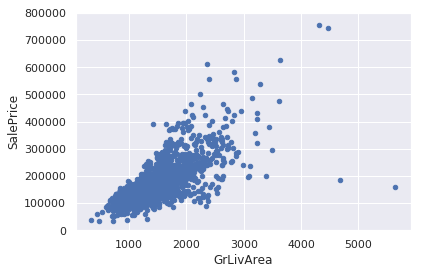

In [532]:
#saleprice/grlivarea
train.plot.scatter(x='GrLivArea', y='SalePrice', ylim=(0,800000));

The two values with bigger GrLivArea seem strange and they are not following the crowd. There could be an explanation for this but i'll simply consider them outliers and remove them. 

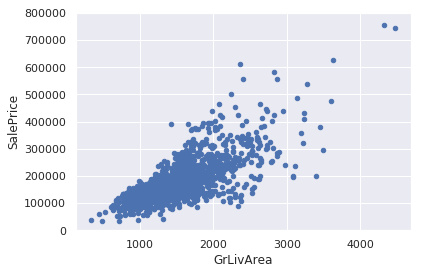

In [533]:
#deleting points
train.sort_values(by = 'GrLivArea', ascending = False)[:2]
train = train.drop(train[train['Id'] == 1299].index)
train = train.drop(train[train['Id'] == 524].index)

#saleprice/grlivarea updated
train.plot.scatter(x='GrLivArea', y='SalePrice', ylim=(0,800000));

Looks better!

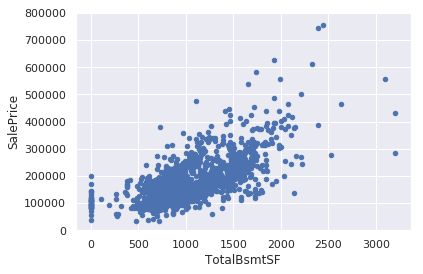

In [534]:
#TotalBsmtSF/grlivarea
train.plot.scatter(x='TotalBsmtSF', y='SalePrice', ylim=(0,800000));

They somewhat follow the trend and I can live with that

# 4. Dummies

In [535]:
test_features = test
train_features = train.drop('SalePrice',1)
labels = train['SalePrice']
all_features = pd.concat([train_features,test_features])

In [536]:
all_features = pd.get_dummies(all_features)

In [537]:
all_features.shape

(2916, 220)

# 5. Statistical analysis

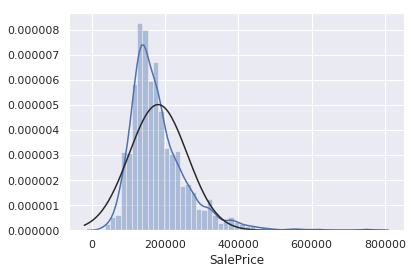

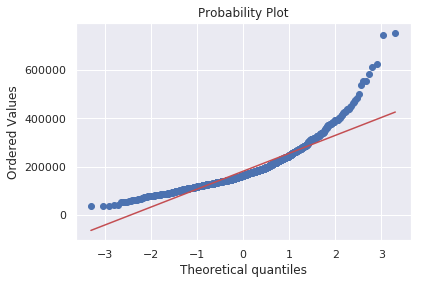

In [538]:
#histogram and normal probability plot 
sns.distplot(labels, fit=norm);
fig = plt.figure() 
res = stats.probplot(train['SalePrice'], plot=plt)

Sale price shows 'peakedness', positive skewness and does not follow the diagonal line. A simple data transformation can solve the problem: in case of positive skewness, log transformations usually works well.

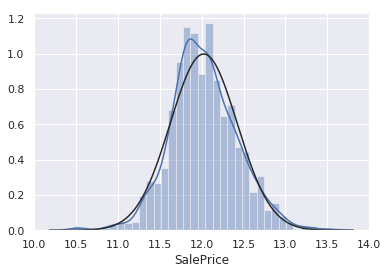

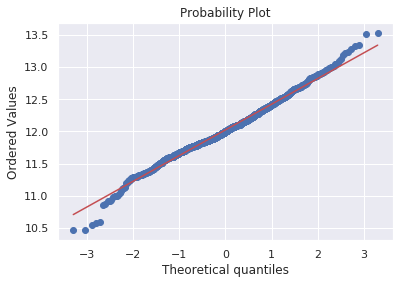

In [539]:
#applying log transformation
labels = np.log(labels)

#transformed histogram and normal probability plot
sns.distplot(labels, fit=norm);
fig = plt.figure()
res = stats.probplot(labels, plot=plt)

Looks way better!

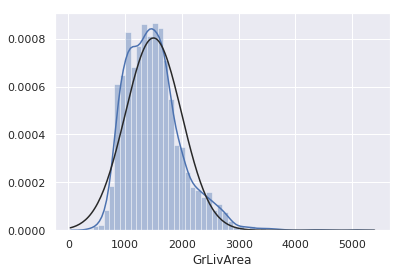

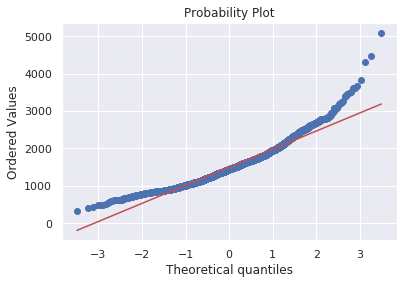

In [540]:
#GrLivArea histogram and normal probability plot
sns.distplot(all_features['GrLivArea'], fit=norm);
fig = plt.figure()
res = stats.probplot(all_features['GrLivArea'], plot=plt)

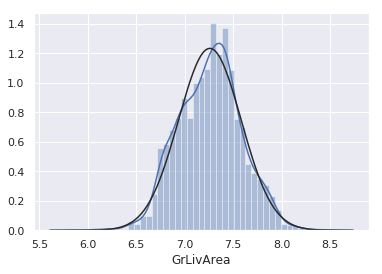

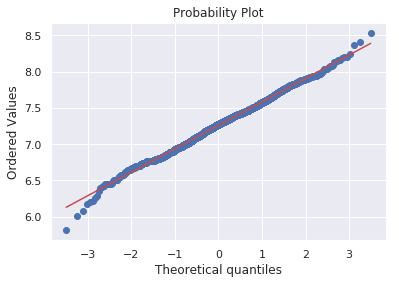

In [541]:
#applying log transformation
all_features['GrLivArea'] = np.log(all_features['GrLivArea'])

#transformed histogram and normal probability plot
sns.distplot(all_features['GrLivArea'], fit=norm);
fig = plt.figure()
res = stats.probplot(all_features['GrLivArea'], plot=plt)

All right!

In [542]:
# split concatonated data into train and test dataframes

X_train = all_features[:train_features.shape[0]]
X_test = all_features[train_features.shape[0]:]

# Model

* Linear Regression
* Lasso Regression
* XGBoost

In [543]:
# Root-Mean-Squared-Error (RMSE) evaluation metric
from sklearn.model_selection import cross_val_score

# from "Regularized Linear Models" w/ cross validation
def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, labels, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

In [544]:
# Linear Regression
from sklearn import linear_model

linear_model = linear_model.LinearRegression()
lr_model = linear_model.fit(X_train, labels)

rmse_cv(lr_model).mean()

0.12062171996759356

In [545]:
# LassoCV
from sklearn.linear_model import LassoCV
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

lasso_model = LassoCV(alphas = [1, 0.1, 0.001, 0.0005, 0.005, 0.0001, 0.5, 0.2]).fit(X_train, labels)
rmse_cv(lasso_model).mean()

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.059445909847976, tolerance: 0.015371137625477463
  tol, rng, random, positive)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.023198711425937546, tolerance: 0.015124015784605553
  tol, rng, random, positive)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4432911191583528, tolerance: 0.015124015784605553
  tol, rng, random, positive)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want 

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0057436528911734, tolerance: 0.011493425280600562
  tol, rng, random, positive)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.311336621485239, tolerance: 0.013399494619629674
  tol, rng, random, positive)


0.11198415286591581

Lasso regression does a much better job than linear regression so I'll stick to that

In [546]:
# XGBoost
from xgboost.sklearn import XGBRegressor
reoptimize=False
nestim = 1921
if(reoptimize):
    learning_rate_grid = np.linspace(0.05, 0.05, 1)
    max_depth_grid = np.linspace(1, 5, 5, dtype='int')
    n_estimators_grid = np.linspace(1000, 2500, 250, dtype='int')

    xgbgrid={
            #'learning_rate' : learning_rate_grid, 
            #'max_depth' : max_depth_grid,
            'n_estimators' : n_estimators_grid }
    xgb_cv=GridSearchCV(XGBRegressor(colsample_bytree=0.2), xgbgrid, cv=4, refit=True, n_jobs=-1, scoring='neg_mean_squared_log_error')

    xgb_cv.fit(X_train, labels)
    print(xgb_cv.best_params_)
    nestim = xgb_cv.best_params_['n_estimators']

In [547]:
from sklearn.base import BaseEstimator, RegressorMixin

class CustomEnsembleRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, regressors=None):
        self.regressors = regressors

    def fit(self, X, y):
        for regressor in self.regressors:
            regressor.fit(X, y)

    def predict(self, X):
        self.predictions_ = list()
        for regressor in self.regressors:
            self.predictions_.append((regressor.predict(X).ravel()))
        return (np.mean(self.predictions_, axis=0))
    
xgb1 = XGBRegressor(colsample_bytree=0.02,
                 learning_rate=0.05,
                 max_depth=3,
                 n_estimators=nestim
                )

xgb2 = XGBRegressor(colsample_bytree=0.2,
                 learning_rate=0.05,
                 max_depth=3,
                 n_estimators=nestim,
                seed = 1234
                )

xgb3 = XGBRegressor(colsample_bytree=0.2,
                 learning_rate=0.05,
                 max_depth=3,
                 n_estimators=nestim,
                seed = 1337
                )

xgb_ens = CustomEnsembleRegressor([xgb1,xgb2,xgb3])
xgb_ens.fit(X_train, labels)

#Trying a different approach for rmse
scores = cross_val_score(cv=4,estimator=xgb_ens,X = X_train,y = labels, n_jobs = -1, scoring='neg_mean_squared_error')
print("cross val scores (xgboost ensemble):" , np.sqrt(-scores))
print('average root mean squared log error (xgboost ensemble)=', np.mean(np.sqrt(-scores)))

[02:31:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:31:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:31:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
cross val scores (xgboost ensemble): [0.0985624  0.13247439 0.10795835 0.12387217]
average root mean squared log error (xgboost ensemble)= 0.11571682735473104


Looks like Lasso + XGBoost might be great for predictions

In [548]:
linear_pred = np.exp(lr_model.predict(X_test))
lasso_pred = np.exp(lasso_model.predict(X_test))
xgb_pred = np.exp(xgb_ens.predict(X_test))

In [549]:
prediction=(lasso_pred+xgb_preds)/2

In [550]:
output = pd.DataFrame({"id":test.Id, "SalePrice":prediction})
output.to_csv("solution.csv", index = False)